In [1]:
%matplotlib inline
from matplotlib import style
style.use('seaborn-darkgrid')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x29e46f72470>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [11]:
# Display the row's columns and data in dictionary format
first_rowM = session.query(Measurement).first()
first_rowM.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x29e46f72d30>,
 'id': 1,
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397'}

In [12]:
# Create Last Date Information
last_date = session.query(Measurement.date).\
   order_by(Measurement.date.desc()).first().date
last_date

'2017-08-23'

In [13]:
# Create Past 12 Month Date
past12mth_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
past12mth_date

datetime.date(2016, 8, 23)

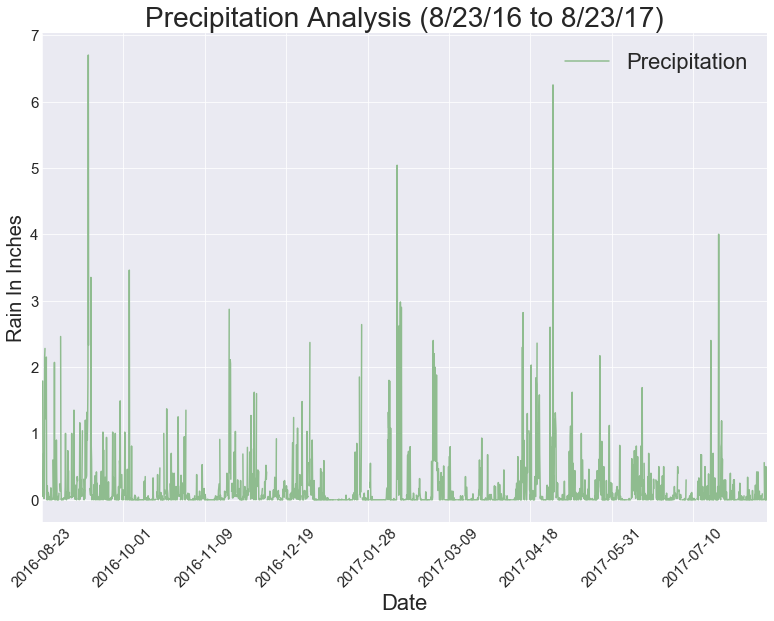

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past12mth_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
query1 = pd.DataFrame(query, columns=['Date', 'Precipitation'])
query2 = query1.set_index('Date')
query3 = query2.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
colors = ["darkseagreen"]
query3.plot(x_compat=True, figsize=(13,9), color=colors)
plt.yticks(fontsize = 15)
plt.xlabel('Date',fontsize=22)
plt.legend(fontsize=22)
plt.title('Precipitation Analysis (8/23/16 to 8/23/17)',fontsize=28)
plt.ylabel("Rain In Inches", fontsize=20)
plt.xticks(rotation=45, fontsize=15)

# Save Png
plt.savefig('Images/precipitation.png')

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query3.describe()

NameError: name 'query3' is not defined

In [170]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(func.count(Station.station)).all()

# Create Data Frame For Total Stations
total_stations = pd.DataFrame(total_stations, columns=['Total Stations'])
total_stations

,Total Stations
0,9


In [187]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_count = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Create Data Frame For Total Stations
stations_count = pd.DataFrame(stations_count, columns=['Station ID', 'Data Count'])
stations_count

,Station ID,Data Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [55]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
temps = session.query(Measurement.station, Measurement.tobs).all()

# Create Data Frame For Temps
temps = pd.DataFrame(temps, columns=['Station_ID', 'Temp'])
temps = temps.set_index("Station_ID")
temps = temps.loc['USC00519281']

# Retrieve MIN MAX and MEAN
temp_stats = temps.agg({'Temp':['min','max','mean']})
temp_stats

,Temp
min,54.000000
max,85.000000
mean,71.663781


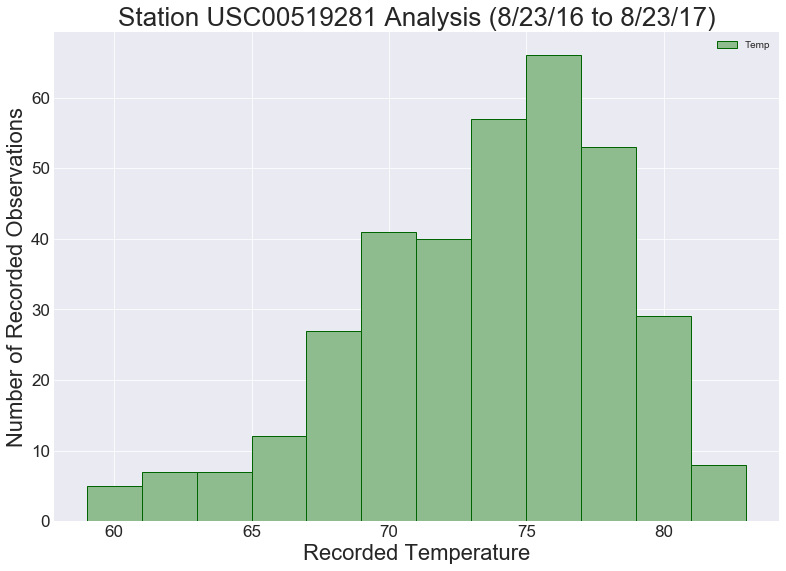

In [183]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_12_months = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
filter(Measurement.station=='USC00519281').\
filter(Measurement.date >= past12mth_date).all()

# Create Data Frame For Temps Over a 12 Month Period Of Time
temps_12_months = pd.DataFrame(temps_12_months, columns=['Date', 'Station_ID', 'Temp'])

# Create Histogram Plot For Station Analysis
temps_12_months.plot.hist(bins=12, color=colors, figsize=(13,9), edgecolor="darkgreen")
plt.title("Station USC00519281 Analysis (8/23/16 to 8/23/17)", fontsize = 26)
plt.yticks(fontsize = 17)
plt.ylabel('Number of Recorded Observations',fontsize=22)
plt.xticks(fontsize = 17)
plt.xlabel("Recorded Temperature",fontsize=22)

# Save Png
plt.savefig('Images/station-histogram.png')

In [58]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [178]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_year = calc_temps('2016-8-23', '2017-08-23')

# Create Data Frame For plot
year_temp = pd.DataFrame(previous_year, columns=["Min", "Avg", "Max"])
year_temp.head()

,Min,Avg,Max
0,58.0,74.14388,87.0


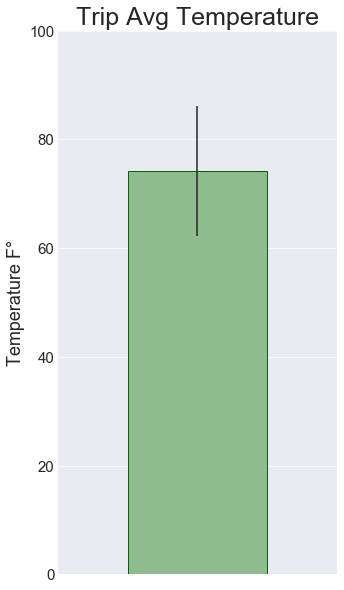

In [179]:
# Plot the results from your previous query as a bar chart for avg.
year_temp["Avg"].plot.bar(yerr=60-48, color=colors, edgecolor="darkgreen", figsize=(5,10))
plt.title("Trip Avg Temperature", fontsize=(25))
plt.yticks(fontsize=(15))
plt.xticks([])
plt.ylabel('Temperature F°', fontsize=18)
plt.ylim(0, 100)

# Save Png
plt.savefig('Images/Trip_AVG_Temp.png')

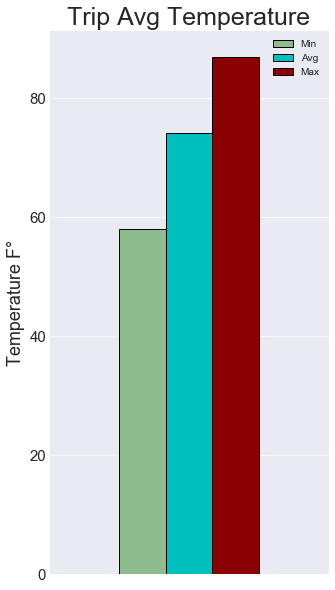

In [138]:
# Plot the results from your previous query as a bar chart. 
colors = ["darkseagreen", "c", "darkred"]
year_temp.plot.bar(color=colors, edgecolor="black", figsize=(5,10))
plt.title("Trip Avg Temperature", fontsize=(25))
plt.yticks(fontsize=(15))
plt.xticks([])
plt.ylabel('Temperature F°', fontsize=18)

# Save Png
plt.savefig('Images/Trip_AVG_Min_Max_Temp.png')

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total=session.query(Measurement.station,Station.name, Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
.join(Station, Station.station == Measurement.station).filter(Measurement.date >= past12mth_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
total

[('USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1330.2899999999968),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  630.2699999999984),
 ('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  436.5899999999951),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  342.0899999999993),
 ('USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  299.15999999999997),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  144.81000000000117),
 ('USC00517948',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  41.30999999999996)]